In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
import os
import shutil
from collections import Counter
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D,Dense, Layer, Reshape, InputLayer, Flatten, Input, MaxPooling2D
from alibi_detect.od import OutlierAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

2023-01-19 11:19:54.752865: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-19 11:19:54.752914: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def img_to_np(path, resize = True):  
    img_array = []
    fpaths = glob.glob(path, recursive=True)
    for fname in fpaths:
        img = Image.open(fname).convert("RGB")
        if(resize): img = img.resize((64,64))
        img_array.append(np.asarray(img))
    images = np.array(img_array)
    return images

In [21]:
path_train = "capsule/train/good/*.png"

In [23]:
path_test = "capsule/test/**/*.*"

In [20]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [22]:
train = img_to_np(path_train)

In [24]:
test = img_to_np(path_test)

In [25]:
train = train.astype('float32') / 255.
test = test.astype('float32') / 255.

In [26]:
encoding_dim = 1024
dense_dim = [8, 8, 128]

In [27]:
encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=train[0].shape),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ])

2023-01-19 11:32:08.520022: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-19 11:32:08.520600: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-19 11:32:08.520631: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-19 11:32:08.520686: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (instance-4.us-central1-a.c.deloitte-team1.internal): /proc/driver/nvidia/version does not exist
2023-01-19 11:32:08.521585: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other oper

In [28]:
decoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(encoding_dim,)),
      Dense(np.prod(dense_dim)),
      Reshape(target_shape=dense_dim),
      Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
  ])

In [29]:
od = OutlierAE( threshold = 0.001,
                encoder_net=encoder_net,
                decoder_net=decoder_net)

In [30]:
adam = tf.keras.optimizers.Adam(lr=1e-4)

In [31]:
od.fit(train, epochs=100, verbose=True,
       optimizer = adam)

3/3 [=] - 4s 1s/step - loss_ma: 6.0062e-04


In [32]:
od.infer_threshold(test, threshold_perc=95)

In [33]:
preds = od.predict(test, outlier_type='instance',
            return_instance_score=True,
            return_feature_score=True)

In [42]:
preds

{'data': {'instance_score': array([0.00029543, 0.0003691 , 0.00027853, 0.00050588, 0.00051445,
         0.00023555, 0.00048059, 0.00019871, 0.00052491, 0.00023543,
         0.00085996, 0.00043454, 0.00034212, 0.00083003, 0.00031069,
         0.00063114, 0.00044132, 0.00064161, 0.00020556, 0.00044134,
         0.00024657, 0.00314576, 0.00143419, 0.00030802, 0.00067574,
         0.00019983, 0.00040949, 0.00028853, 0.00037862, 0.00020283,
         0.00033209, 0.00041351, 0.00037074, 0.00058547, 0.00028504,
         0.00046903, 0.00039152, 0.00046427, 0.00026128, 0.00035262,
         0.00019608, 0.00036678, 0.00080371, 0.00020554, 0.00032061,
         0.00062356, 0.00023678, 0.0001216 , 0.00025641, 0.00067532,
         0.00029007, 0.00046721, 0.0001732 , 0.0009649 , 0.00042177,
         0.00029428, 0.00034386, 0.00015451, 0.00031746, 0.00037137,
         0.00037689, 0.00029674, 0.00065974, 0.0002459 , 0.00024092,
         0.00023694, 0.00037309, 0.00021382, 0.00069433, 0.00012604,
        

In [45]:
for i, fpath in enumerate(glob.glob(path_test)):
    if(preds['data']['is_outlier'][i] == 1):
        source = fpath
        shutil.copy(source, 'olier/')

PermissionError: [Errno 13] Permission denied: 'olier/001.png'

In [46]:
filenames = [os.path.basename(x) for x in glob.glob(path_test, recursive=True)]

In [47]:
dict1 = {'Filename': filenames,
     'instance_score': preds['data']['instance_score'],
     'is_outlier': preds['data']['is_outlier']}

In [48]:
dict1

{'Filename': ['013.png',
  '009.png',
  '016.png',
  '020.png',
  '002.png',
  '005.png',
  '017.png',
  '000.png',
  '012.png',
  '015.png',
  '011.png',
  '018.png',
  '014.png',
  '004.png',
  '008.png',
  '021.png',
  '006.png',
  '019.png',
  '007.png',
  '003.png',
  '022.png',
  '001.png',
  '010.png',
  '013.png',
  '009.png',
  '016.png',
  '020.png',
  '002.png',
  '005.png',
  '017.png',
  '000.png',
  '012.png',
  '015.png',
  '011.png',
  '018.png',
  '014.png',
  '004.png',
  '008.png',
  '021.png',
  '006.png',
  '019.png',
  '007.png',
  '003.png',
  '022.png',
  '001.png',
  '010.png',
  '013.png',
  '009.png',
  '016.png',
  '020.png',
  '002.png',
  '005.png',
  '017.png',
  '000.png',
  '012.png',
  '015.png',
  '011.png',
  '018.png',
  '014.png',
  '004.png',
  '008.png',
  '006.png',
  '019.png',
  '007.png',
  '003.png',
  '001.png',
  '010.png',
  '013.png',
  '009.png',
  '016.png',
  '020.png',
  '002.png',
  '005.png',
  '017.png',
  '000.png',
  '012.png',


In [49]:
df = pd.DataFrame(dict1)
df_outliers = df[df['is_outlier'] == 1]

In [50]:
print(df_outliers)

    Filename  instance_score  is_outlier
21   001.png        0.003146           1
112  013.png        0.002158           1
113  009.png        0.002648           1
120  015.png        0.002860           1
123  014.png        0.003738           1
128  007.png        0.004236           1
130  001.png        0.003750           1


In [51]:
recon = od.ae(test).numpy()

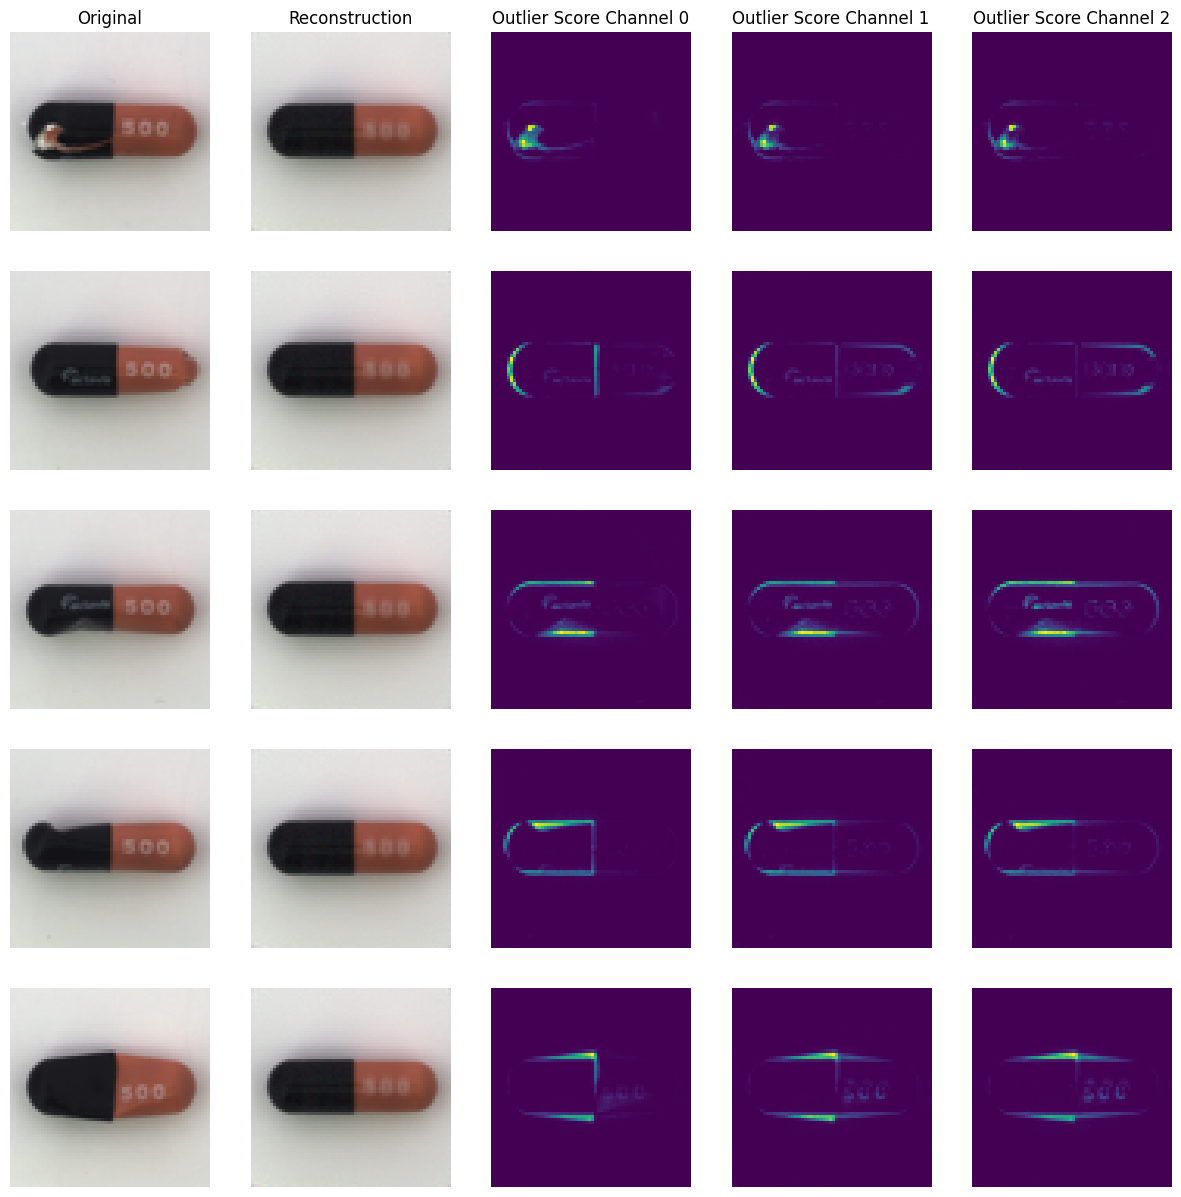

In [52]:
plot_feature_outlier_image(preds, test, 
                           X_recon=recon,  
                           max_instances=5,
                           outliers_only=True,
                           figsize=(15,15))